# Processament i visualització

In [1]:
# Imports
import io
import os
import tqdm
import requests

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from pprint import pprint
import pyarrow.parquet as pq
from collections import Counter



In [ ]:
# Scrapping the XAC database

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

webdriver.firefox.marionette=False
# El rows = 1000 travieso és per aprofitar el bug
BASE_ARXIU = 'https://arxiusenlinia.cultura.gencat.cat'
QUERY_GLOBAL = BASE_ARXIU +'/#/cercaavancada/cerca'

option = webdriver.ChromeOptions()
option.add_experimental_option("excludeSwitches", ["enable-automation"])
option.add_experimental_option('useAutomationExtension', False)

#For ChromeDriver version 79.0.3945.16 or over
option.add_argument('--disable-blink-features=AutomationControlled')

option.add_argument("window-size=1280,800")
option.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36")

DRIVERPATH = 'geckodriver' 
OUPATH = 'arxiu/'
DRIVER = webdriver.Chrome(options=option)
DRIVER.get(QUERY_GLOBAL)

DRIVER.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

def check_if_loading():
    try:
        return DRIVER.find_element(By.CLASS_NAME, 'spinner-container').is_displayed
    except NoSuchElementException:
        return False

def scrap():
    while True:
        # while check_if_loading(): pass
    
        for element in BeautifulSoup(DRIVER.page_source, features="html.parser").find('table').find_all(class_='row'):
            soup_elelment = element # METADATA FROM HERE
            photo = soup_elelment.find('img', class_ = 'image-list-item-responsive')
            if photo is not None:
                if photo['src'] in visited: continue # Cal fer-ho en dos nivells perque si és None no és iterable per tant no té "in" 
            desc = soup_elelment.find_all(class_ = 'contingut-nom-metadada')
            if not len(desc): continue
            try:
                date = desc[2].find_next_siblings('span')[0]
            except IndexError:
                date = "<span>1/1/0000</span>" # Placeholder
            desc = desc[-1].find_next_siblings('span')
            title = soup_elelment.find(class_ = 'titol-text-resultats')
            if photo is not None and title is not None and desc is not None:
                photo = photo['src']
                title = title
                desc = desc[0]
                date = date
    
                data = {
                    'image': str(photo),
                    'caption': str(title).replace('\n', ' '),
                    'desc': str(desc).replace('\n', ' '),
                    'date': str(date)
                }
                visited.add(photo)
                
                CSV.write("\n" + '\t'.join(list(data.values()))) # Separat per tabulacions per evitar problemes de parsing amb les commes de les fotos i descripcions
        succeed = False
        while not succeed:
            # De vegades el botó de següent está oclòs ja que BS4 va més ràpid que selenium carregant les coses, per algun motiu comprobar el display no funciona
            try:
                next = WebDriverWait(DRIVER, 10).until(
                    EC.element_to_be_clickable((By.CLASS_NAME, 'ui-paginator-next'))
                )
                next.click()
                succeed = True
            except: pass
            

input("Press enter to proceed... ") # Cal inserir la cerca manualment perque funciona desde front-end; tirem de selenium
CSV = open('imatges2.tsv', 'w')
CSV.write('\t'.join(['url', 'caption', 'desc', 'date']))
visited = set()
scrap()

In [ ]:
# Functions to download images from XAC (previously scrapped) and resize them

def download_images(data, data_location, check_unique=True, train_test_split=0.8):
    """

    Args:
        data: File name with the url, captions and description of the images
        data_location: Directory name where the data is stored
        check_unique: Bool to check unique captions (deletes duplicate captions)
        train_test_split: Ratio of images for train

    """
    train_dir = os.path.join(data_location, 'train')
    test_dir = os.path.join(data_location, 'test')

    # Create dataframe for images
    images_df = pd.read_csv(os.path.join(data_location, data), sep='\t', encoding="ISO-8859-1")

    # Create captions files
    with open(os.path.join(data_location, "captions_train_raw.tsv"), "w") as f:
        f.write("image\tcaption\n")

    with open(os.path.join(data_location, "captions_test_raw.tsv"), "w") as f:
        f.write("image\tcaption\n")

    id = 0
    unique_captions = set()
    if check_unique:
        # Download images from url and fill captions file
        for url, caption in zip(images_df.url.values, images_df.caption.values):
            name = os.path.split(url)[1]
            caption = caption[35:-7]
            if caption in unique_captions:
                id += 1
                continue
            unique_captions.add(caption)
            r = requests.get(url, stream=True)

            if r.status_code == 200:
                i = Image.open(io.BytesIO(r.content))

                if np.random.rand() < train_test_split:
                    i.save(os.path.join(train_dir, name), quality=95)
                    with open(os.path.join(data_location, "captions_train_raw.tsv"), "a") as f:
                        f.write(name + "\t" + caption + "\n")
                else:
                    i.save(os.path.join(test_dir, name), quality=95)
                    with open(os.path.join(data_location, "captions_test_raw.tsv"), "a") as f:
                        f.write(name + "\t" + caption + "\n")

            if (id % 100) == 0:
                print(
                    f"Progress: {id}/{len(images_df.url.values)} with {len(unique_captions)} unique captions so far.\n")
            id += 1
    else:
        # Download images from url and fill captions file
        for url, caption in zip(images_df.url.values, images_df.caption.values):
            name = os.path.split(url)[1]
            caption = caption[35:-7]
            r = requests.get(url, stream=True)

            if r.status_code == 200:
                i = Image.open(io.BytesIO(r.content))

                if np.random.rand() < train_test_split:
                    i.save(os.path.join(train_dir, name), quality=95)
                    with open(os.path.join(data_location, "captions_train_raw.tsv"), "a") as f:
                        f.write(name + "\t" + caption + "\n")
                else:
                    i.save(os.path.join(test_dir, name), quality=95)
                    with open(os.path.join(data_location, "captions_test_raw.tsv"), "a") as f:
                        f.write(name + "\t" + caption + "\n")

            if (id % 100) == 0:
                print(f"Progress: {id}/{len(images_df.url.values)} \n")
            id += 1
    print('Finished downloading all images')


def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.Resampling.LANCZOS)
                img.save(os.path.join(output_dir, image), img.format)
        if (i + 1) % 100 == 0:
            print("[{}/{}] Resized the images and saved into '{}'."
                  .format(i + 1, num_images, output_dir))


def resize_images_dew(data, output_dir, root_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if type(data) == tuple:
        data_0 = pd.read_csv(data[0], header=None, sep=',')
        data_1 = pd.read_csv(data[1], header=None, sep=',')
        data = pd.concat([data_0, data_1])
        del data_0, data_1
    else:
        data = pd.read_csv(data, header=None, sep=',')
    names = data[1]

    num_images = len(names)
    for i, image in enumerate(names):
        image = str(image)
        with open(os.path.join(root_dir, image[:1], image[1:3], image + '.jpg'), 'rb') as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.Resampling.LANCZOS)
                img.save(os.path.join(output_dir, image + '.jpg'), img.format)
        if (i + 1) % 100 == 0:
            print("[{}/{}] Resized the images and saved into '{}'."
                  .format(i + 1, num_images, output_dir))

In [ ]:
# Distribució d'idiomes del subset sencer

filename = "part-00000-fc82da14-99c9-4ff6-ab6a-ac853ac82819-c000.snappy.parquet"
print(pq.ParquetFile(filename).schema)
df = pq.read_table(filename).to_pandas()

langs = dict()
for el in df['LANGUAGE'].values:
    print(el)
    if el not in langs.keys():
        langs[el] = 1
    else:
        langs[el] += 1

pprint(langs)

In [ ]:
# Netejar train original per incloure només imatges decarregades

df = pd.read_csv('/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/laion/train.csv', sep='\t')
imgs = os.listdir('/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/laion/img_size/')

imgs = set(imgs)
langs = dict()
rmv = list()

with tqdm.tqdm(total=len(imgs)) as pbar:
    for i, id, lang in zip(df.index, df['SAMPLE_ID'], df['LANGUAGE']):
        if str(id) + '.jpg' in imgs:
            if lang not in langs.keys():
                langs[lang] = 1
            else:
                langs[lang] += 1
            pbar.update(1)
        else:
            rmv.append(i)

pprint(langs)

df = df.drop(rmv)
df.to_csv('clean_train.csv', sep='\t')
print(len(df))

In [ ]:
# Canviar format caption

file_path = '/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/laion/captions.jsonl'
caps = pd.read_json(path_or_buf=file_path, lines=True)

langs = caps.columns[2:]
caps_2 = list()

for i in caps.index:
    for lang in langs:
        row = {'image/key': caps['image/key'].iloc[i], 'image/locale': caps['image/locale'].iloc[i],
               'caption': caps[lang].iloc[i]['caption'][0], 'lang': lang}
        caps_2.append(row)
        if len(caps[lang].iloc[i]['caption']) > 1:
            row = {'image/key': caps['image/key'].iloc[i], 'image/locale': caps['image/locale'].iloc[i],
                   'caption': caps[lang].iloc[i]['caption'][1], 'lang': lang}
            caps_2.append(row)

df = pd.DataFrame(caps_2)

df.to_csv('captions.tsv', sep='\t')

In [ ]:
# Anàlisi de les coincidències entre etiquetatges de llenguatges i similarity

from langid.langid import LanguageIdentifier, model


file_path = 'final_train.csv'
df = pd.read_csv(file_path, sep='\t')
langs = np.unique(df['LANGUAGE'])
print(len(langs))
unknown = ['co', 'fy', 'gd', 'ha', 'iw', 'mi', 'my', 'sd', 'sm', 'sn', 'so', 'st', 'su', 'tg', 'uz', 'yi', 'yo']
ids = [i for i, x in enumerate(langs) if x in unknown]
langs = np.delete(langs, ids)
langs = np.append(langs, 'en')
print(langs)

identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
identifier.set_languages(langs)
print(identifier.classify("This is a test")[0])


similarity27 = df[df['similarity'] > 0.27]
similarity28 = df[df['similarity'] > 0.28]
similarity29 = df[df['similarity'] > 0.29]
similarity30 = df[df['similarity'] > 0.3]

print('0.27:', len(similarity27),
      similarity27['TEXT'].head(30),
      '\n0.28:', len(similarity28),
      similarity28['TEXT'].head(30),
      '\n0.29:', len(similarity29),
      similarity29['TEXT'].head(30),
      '\n0.30:', len(similarity30),
      similarity30['TEXT'].head(30))

preds = [identifier.classify(text)[0] for text in df['TEXT']]
origi = df['LANGUAGE']
cnt_ori = dict(Counter(origi))
cnt_ori['en'] = 0

cnt_prd = dict(Counter(preds))
for lang in unknown:
    cnt_prd[lang] = 0

cnt_prd = dict(sorted(cnt_prd.items(), key=lambda x: x[1], reverse=True))
cnt_ori = dict(sorted(cnt_ori.items(), key=lambda x: x[1], reverse=True))

df_prd = pd.DataFrame(cnt_prd.items(), columns=['language', 'count'])
df_ori = pd.DataFrame(cnt_ori.items(), columns=['language', 'count'])

en_pred = [pred == 'en' for pred in preds]
accuracy = [pred == org for pred, org in zip(preds, origi)]
print("Percentatge d'anglès:", sum(en_pred)/len(en_pred)*100,
      "Precisió respecte l'original:", sum(accuracy)/len(accuracy)*100)

sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(17, 8))

sns.set_color_codes("pastel")
sns.barplot(x="language", y="count", data=df_ori,
            label="Original", color="b")

sns.set_color_codes("muted")
sns.barplot(x="language", y="count", data=df_prd,
            alpha=0.5, label="Predicted", color="r")

# Add a legend and informative axis label
plt.xticks(rotation=90)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(title="Language labels accuracy", ylabel="Count", xlabel="Languages")
sns.despine(left=True, bottom=True)


f.savefig('comparison.png')

In [ ]:
# Anàlisi de les coincidències entre etiquetatges de llenguatges i similarity

from langid.langid import LanguageIdentifier, model
from collections import defaultdict

file_path = 'final_train.csv'
df = pd.read_csv(file_path, sep='\t')
langs = np.unique(df['LANGUAGE'])
print(len(langs))
unknown = ['co', 'fy', 'gd', 'ha', 'iw', 'mi', 'my', 'sd', 'sm', 'sn', 'so', 'st', 'su', 'tg', 'uz', 'yi', 'yo']
ids = [i for i, x in enumerate(langs) if x in unknown]
langs = np.delete(langs, ids)
langs = np.append(langs, 'en')
print(langs)
all_langs = np.append(langs, unknown)

identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
identifier.set_languages(langs)
print(identifier.classify("This is a test")[0])

preds = [identifier.classify(text)[0] for text in df['TEXT']]
origi = df['LANGUAGE']
similarity = np.array(df['similarity'])

idx_preds = defaultdict(list)
for i, lang in enumerate(preds):
    idx_preds[lang].append(i)

idx_origi = defaultdict(list)
for i, lang in enumerate(origi):
    idx_origi[lang].append(i)

mean_preds = {lang: np.mean(similarity[i]) for lang, i in idx_preds.items()}
mean_origi = {lang: np.mean(similarity[i]) for lang, i in idx_origi.items()}

df_prd = pd.DataFrame(mean_preds.items(), columns=['language', 'clip'])
df_ori = pd.DataFrame(mean_origi.items(), columns=['language', 'clip'])

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(17, 8))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.catplot(data=df_ori, x='language', y='clip',
            label="Original", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.catplot(data=df_prd, x='language', y='clip',
            alpha=0.8, label="Predicted", color="r")

# Add a legend and informative axis label
plt.xticks(rotation=90)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(title="Language labels similarity", ylabel="CLIP similarity mean", xlabel="Languages")
sns.despine(left=True, bottom=True)

f.savefig('similarity.png')

In [ ]:
# Confusion matrix llenguatges

from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap


df = pd.read_csv('preds.csv', sep='\t')
labels = np.unique(df['prediccio'])
matplotlib.rcParams['figure.figsize'] = 19, 15
cm = confusion_matrix(df['original'], df['prediccio'], labels=labels)

magma = matplotlib.colormaps['magma'].reversed()
cmap = ListedColormap(magma(np.linspace(0.1, 1, 256)))
cmap.set_bad('white')      # color of mask on heatmap
cmap.set_under('white')    # color of mask on cbar

sns.heatmap(cm,
    cmap=cmap, vmin=5,            # set cbar range from 0.5 to 1
    mask=cm < 5,                  # use "bad" color for thresholded values
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'extend': 'min'})     # extend cbar to show "under" color

plt.savefig('confusionmatrix.png')

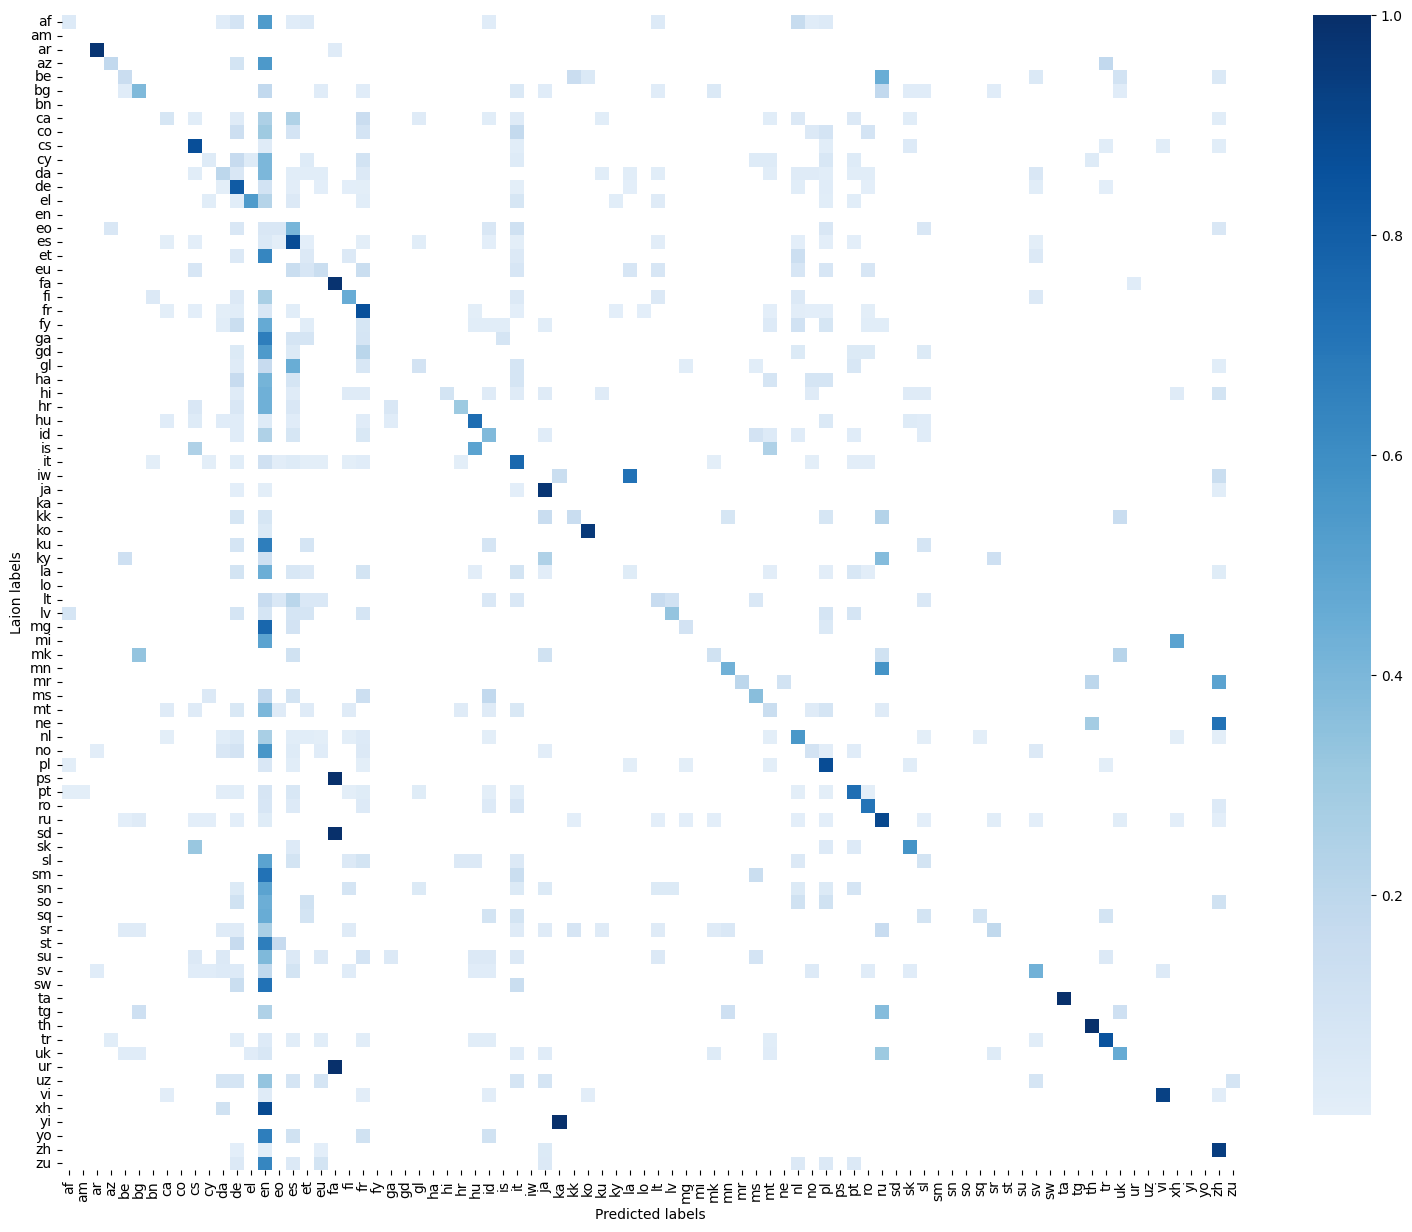

In [4]:
# Confusion matrix percentatges

from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

df = pd.read_csv('preds.csv', sep='\t')
total = pd.read_csv('/data2fast/users/esanchez/laion/clean_train.csv', sep='\t')

labels_pred = set(np.unique(df['prediccio']))
labels_origi = np.unique(df['original'])
labels_pred.update(labels_origi)
labels = sorted(list(labels_pred))
matplotlib.rcParams['figure.figsize'] = 19, 15
cm = confusion_matrix(df['original'], df['prediccio'], labels=labels)
cm = np.array([(row / np.sum(row)) if np.sum(row) > 0 else row for row in cm])


threshold = 0
del_list = list()
for i, row in enumerate(cm):
    if row[i] < threshold:
        del_list.append(i)

del_list = list(reversed(del_list))
cm = np.delete(cm, del_list, 0)
cm = np.delete(cm, del_list, 1)
labels = np.delete(labels, del_list)

magma = matplotlib.colormaps['Blues']
cmap = ListedColormap(magma(np.linspace(0.1, 1, 256)))
cmap.set_bad('white')      # color of mask on heatmap
cmap.set_under('white')    # color of mask on cbar

sns.heatmap(cm,
    cmap=cmap, vmin=0.0001,            # set cbar range from 0.5 to 1
    mask=cm == 0,                  # use "bad" color for thresholded values
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'extend': 'min'})     # extend cbar to show "under" color
plt.xlabel('Predicted labels')
plt.ylabel('Laion labels')
plt.savefig('confusionmatrix_0.png')

In [ ]:
# Crear dataset de coincidències

df = pd.read_csv('preds.csv', sep='\t')
total = pd.read_csv('/data2fast/users/esanchez/laion/clean_train.csv', sep='\t')
df = df[df['prediccio'] == df['original']]

total = total.iloc[df.index]
print(total)

names = total.columns
unnamed = [name for name in names if name[:3] == 'Unn']
total = total.drop(columns=unnamed)
total.to_csv('train_coincidences.csv', sep='\t')

In [ ]:
# Fer recompte de les llengües

df = pd.read_csv('train_coincidences.csv', sep='\t')
cnt = dict(Counter(df['LANGUAGE']))

cnt = dict(sorted(cnt.items(), key=lambda x: x[0]))
df_cnt = pd.DataFrame(cnt.items(), columns=['language', 'count'])

df_cnt.to_csv('count.csv', index=False)

In [ ]:
df = pd.read_csv('count.csv')

sns.set_theme(style="whitegrid")
sns.set_theme(rc={'figure.figsize': (15, 8)})

ax = sns.barplot(df, x="language", y="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set(ylim=(0, 1.6e6), ylabel="Amount of samples", xlabel="Language codes")
sns.despine(left=True, bottom=True)

fig = ax.get_figure()
fig.savefig('laion_count.png')

In [ ]:
# Crear arxiu scenes del dataset DeBoer

path = '/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/deboer/scene_detection_set'
classes = next(os.walk(path))[1]
dirs = [os.path.join(path, fold) for fold in classes]

numberOfRows = len([[name for name in os.listdir(fold) if os.path.isfile(name)] for fold in dirs])
print(numberOfRows)

# dsp anar afegint les dades per carpetes (escenes)
df = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['file', 'scene'])
i = 0
for name in classes:
    dir_path = os.path.join(path, name)
    new = [{'file': file, 'scene': name} for file in os.listdir(dir_path) if os.path.isfile(file)]
    df.iloc[i:i+len(new)] = new
    i += len(new)

df.to_csv('scenes.csv')

In [ ]:
# Separar dataset en train i test

import pandas as pd
import numpy as np

df = pd.read_csv("/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/deboer/scenes.csv")
df = df[['file', 'scene']]

train = df.copy()
test = None
scenes = np.unique(df.scene)
del_rows = list()

split = 0.05
for scene in scenes:
    total = np.sum(df.scene == scene)
    n_test = int(total * split)

    idx = np.random.choice(total, size=n_test, replace=False)
    rows = df[df.scene == scene].iloc[idx]

    if test is None:
        test = pd.DataFrame(rows)
    else:
        test = pd.concat([test, rows], ignore_index=True)
    del_rows.extend(rows.index)

test.reset_index(inplace=True, drop=True)
train.drop(del_rows, inplace=True)
train.reset_index(inplace=True, drop=True)


test.to_csv("/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/deboer/test.csv")
train.to_csv("/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/deboer/train.csv")

In [ ]:
# Separar dataset en train i test

split = 0.05

df = pd.read_csv('captions.tsv', sep='\t')
total = len(df)

idx = np.sort(np.random.choice(total, int(total*split), replace=False))

test = df.iloc[idx]

idx_neg = [i not in idx for i in range(total)]

train = df[idx_neg]

train.to_csv('train.tsv', sep='\t', index=False)
test.to_csv('test.tsv', sep='\t', index=False)

In [ ]:
# Afegir NER a dades LAION (es, de, nl)

import pandas as pd
import flair
from flair.data import Sentence
from flair.models import SequenceTagger
from tqdm import tqdm


def space_before(caption, tokens):
    j = 1
    space = list()
    caption = caption[j:]
    for idx, token in enumerate(tokens[1:]):
        j = caption.find(token.text)
        space.append(caption[j-1] == " ")
        j += len(token.text)
        caption = caption[j:]
    space.append(False)
    return space


def ner_sentence(caption, tagger):
    sent = Sentence(caption)
    tagger.predict(sent)

    space = space_before(caption, sent.tokens)

    span = list()
    labels = list()
    for label in sent.get_labels():
        aux = label.unlabeled_identifier.split("[")[1].split(":")
        ll = [int(aux[0])]
        aux = aux[1].split("]")
        ll.append(int(aux[0]))
        span.append(ll)
        labels.append(label.value)

    span.reverse()
    labels.reverse()

    caption = [t.text for t in sent.tokens]
    aux = list()
    for ran, label in zip(span, labels):
        caption[ran[0]] = token[label]
        caption[ran[0] + 1:ran[1]] = ''
        if ran[1] - ran[0] > 1:
            aux.extend(range(ran[1] - 1, ran[0], -1))

    for elem in aux:
        try:
            space.pop(elem)
        except IndexError:
            print("caption", caption)
            print("labels", sent.get_labels())
            print("space", space)
            print("aux", aux)
            print("unlabeled_identifier", sent.unlabeled_identifier)
            input()
    out = "".join([f"{t} " if b else t for t, b in zip(caption, space)])
    return out


df = pd.read_csv("/run/user/1001/gvfs/sftp:host=158.109.8.116,port=22345,user=esanchez/data2fast/users/esanchez/laion/train_coincidences.csv", sep='\t')
df = df[df['LANGUAGE'] == 'es']

tagger = SequenceTagger.load("flair/ner-multi-fast")

token = {'LOC': '<loc>', 'ORG': '<org>', 'PER': '<per>', 'MISC': '<misc>'}

handler = open('train_ner.tsv', 'w')
handler.write("SAMPLE_ID\tURL\tTEXT\tHEIGHT\tWIDTH\tLICENSE\tLANGUAGE\tNSFW\tsimilarity\n")

for data in tqdm(df.values):
    _, sample_id, url, text, height, width, license, language, nsfw, similarity = data
    caption = ner_sentence(text, tagger)
    handler.write(f"{sample_id}\t{url}\t{caption}\t{height}\t{width}\t{license}\t{language}\t{nsfw}\t{similarity}\n")

handler.close()


In [ ]:
# Afegir NER a dades LAION (fr, it)

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

device = 'cuda:3'

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True, device=3)

token = {'LOC': '<loc>', 'ORG': '<org>', 'PER': '<per>', 'MISC': '<misc>'}

def masked_string(example, nlp):
    results = nlp(example)
    ll = [*example]
    shift = 0
    for mask in results:
        aux = ll[mask['end'] + shift:]
        ll[mask['start'] + shift:mask['start'] + len(token[mask['entity_group']]) + shift] = [*token[mask['entity_group']]]
        ll = ll[:mask['start'] + len(token[mask['entity_group']]) + shift] + aux
        shift = (mask['start'] + len(token[mask['entity_group']])) - mask['end'] + shift
    return ''.join(ll)

df = pd.read_csv("/data2fast/users/esanchez/laion/train_coincidences.csv", sep='\t')
df = df[(df['LANGUAGE'] == 'fr') | (df['LANGUAGE'] == 'it')]

handler = open('/data2fast/users/esanchez/laion/train_ner_fr_it.tsv', 'w')
handler.write("SAMPLE_ID\tURL\tTEXT\tHEIGHT\tWIDTH\tLICENSE\tLANGUAGE\tNSFW\tsimilarity\n")

for data in tqdm(df.values):
    _, sample_id, url, text, height, width, license, language, nsfw, similarity = data
    caption = masked_string(text, nlp)
    handler.write(f"{sample_id}\t{url}\t{caption}\t{height}\t{width}\t{license}\t{language}\t{nsfw}\t{similarity}\n")

handler.close()

In [2]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

device = "cuda:0"
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(device)
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")
model.eval()

df = pd.read_csv("/data2fast/users/esanchez/coco2017/captions_train.tsv", sep="\t")

/home/esanchez/miniconda3/envs/xac-ic/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import nvidia_smi

def print_memory_stats():
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print(f'Total memory: {info.total} bytes')
    print(f'Free memory: {info.free} bytes')
    print(f'Used memory: {info.used} bytes')
    nvidia_smi.nvmlShutdown()

In [ ]:
class SentenceGetter:
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size

    def __iter__(self):
        i = 0
        while i < len(self.data['caption']):
            # print_memory_stats()
            yield self.data.iloc[i:i+self.batch_size]
            i += self.batch_size
    
sent_loader = SentenceGetter(df[65088:], 32)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
tokenizer.src_lang = "en"

handler = open("train_nl.tsv", "a")
# handler.write("image\tcaption\n")

with torch.no_grad():
    for data in sent_loader:
        images = list(data['image'])
        sentences = list(data['caption'])
        encoded_hi = tokenizer(sentences, **tokenizer_kwargs, return_tensors="pt").to(device)
        generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("nl"), max_length=180)
        output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        handler.write("".join([f"{im}\t{cap}\n" for im, cap in zip(images, output)]))
        del images, sentences, encoded_hi, generated_tokens, output
        torch.cuda.empty_cache()  # Alliberar memòria GPU innecessària

handler.close()

In [ ]:
sent_loader = SentenceGetter(df, 32)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
tokenizer.src_lang = "en"

handler = open("train_de.tsv", "w")
handler.write("image\tcaption\n")

with torch.no_grad():
    for data in sent_loader:
        images = list(data['image'])
        sentences = list(data['caption'])
        encoded_hi = tokenizer(sentences, **tokenizer_kwargs, return_tensors="pt").to(device)
        generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("de"))
        output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        handler.write("".join([f"{im}\t{cap}\n" for im, cap in zip(images, output)]))
        del images, sentences, encoded_hi, generated_tokens, output
        torch.cuda.empty_cache()  # Alliberar memòria GPU innecessària
        
handler.close()

In [ ]:
sent_loader = SentenceGetter(df, 32)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
tokenizer.src_lang = "en"

handler = open("train_es.tsv", "w")
handler.write("image\tcaption\n")

with torch.no_grad():
    for data in sent_loader:
        images = list(data['image'])
        sentences = list(data['caption'])
        encoded_hi = tokenizer(sentences, **tokenizer_kwargs, return_tensors="pt").to(device)
        generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("es"))
        output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        handler.write("".join([f"{im}\t{cap}\n" for im, cap in zip(images, output)]))
        del images, sentences, encoded_hi, generated_tokens, output
        torch.cuda.empty_cache()  # Alliberar memòria GPU innecessària
        
handler.close()

In [ ]:
sent_loader = SentenceGetter(df, 32)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
tokenizer.src_lang = "en"

handler = open("train_it.tsv", "w")
handler.write("image\tcaption\n")

with torch.no_grad():
    for data in sent_loader:
        images = list(data['image'])
        sentences = list(data['caption'])
        encoded_hi = tokenizer(sentences, **tokenizer_kwargs, return_tensors="pt").to(device)
        generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("it"))
        output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        handler.write("".join([f"{im}\t{cap}\n" for im, cap in zip(images, output)]))
        del images, sentences, encoded_hi, generated_tokens, output
        torch.cuda.empty_cache()  # Alliberar memòria GPU innecessària
handler.close()